In [1]:
%load_ext autoreload
%autoreload 2

#import time
import pickle
import numpy as np
from datetime import datetime
import pandas as pd
import urllib.request
from fredapi import Fred
from sklearn.metrics import auc

import time
import numpy as np
from scipy import optimize

from consav.grids import equilogspace
from consav.markov import log_rouwenhorst
from consav.misc import elapsed
import matplotlib.pyplot as plt   

plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

import matplotlib.pyplot as plt   
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams.update({'font.size': 12})

from consav.markov import tauchen, find_ergodic

from HANKSAMModel import HANKSAMModelClass

In [2]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [3]:
model = HANKSAMModelClass(name='baseline')

In [4]:
par = model.par
ss = model.ss
path = model.path
ini = model.ini

In [5]:
# Set initial UI system
par.UI_ratio_high = 0.83
par.UI_ratio_low = 0.54
par.UI_duration = 6.0

In [6]:
model.find_ss(do_print=True)

In [7]:
for varname in model.varlist:
    print(f'{varname:15s}: {ss.__dict__[varname]:.4f}')

shock_TFP      : nan
delta          : 0.0275
w              : 0.7000
px             : nan
Vj             : nan
Vv             : nan
entry          : nan
mu             : nan
M              : nan
errors_Vj      : nan
S              : 0.0840
theta          : nan
lambda_u       : nan
lambda_u_s     : 0.3057
v              : nan
ut             : 0.0920
vt             : nan
errors_vt      : nan
errors_ut      : nan
lambda_v       : nan
errors_Vv      : nan
Pi             : nan
errors_Pi      : nan
R              : nan
RealR          : nan
q              : nan
RealR_ex_post  : nan
tau            : 0.1363
B              : nan
qB             : nan
UI_ratio_high  : 0.8300
guess_U_UI     : nan
UI_duration    : 6.0000
L              : nan
A_hh           : 0.1210
U_POL_hh       : 0.0663
u              : 0.0663
U_UI_hh        : 0.0588
errors_assets  : nan
errors_search  : nan
errors_U_UI    : nan
C_hh           : 0.6906
S_hh           : 0.0840
S_COND_hh      : 0.8655
V_hh           : -435.1670


Text(0, 0.5, 'search, $s_{t}$')

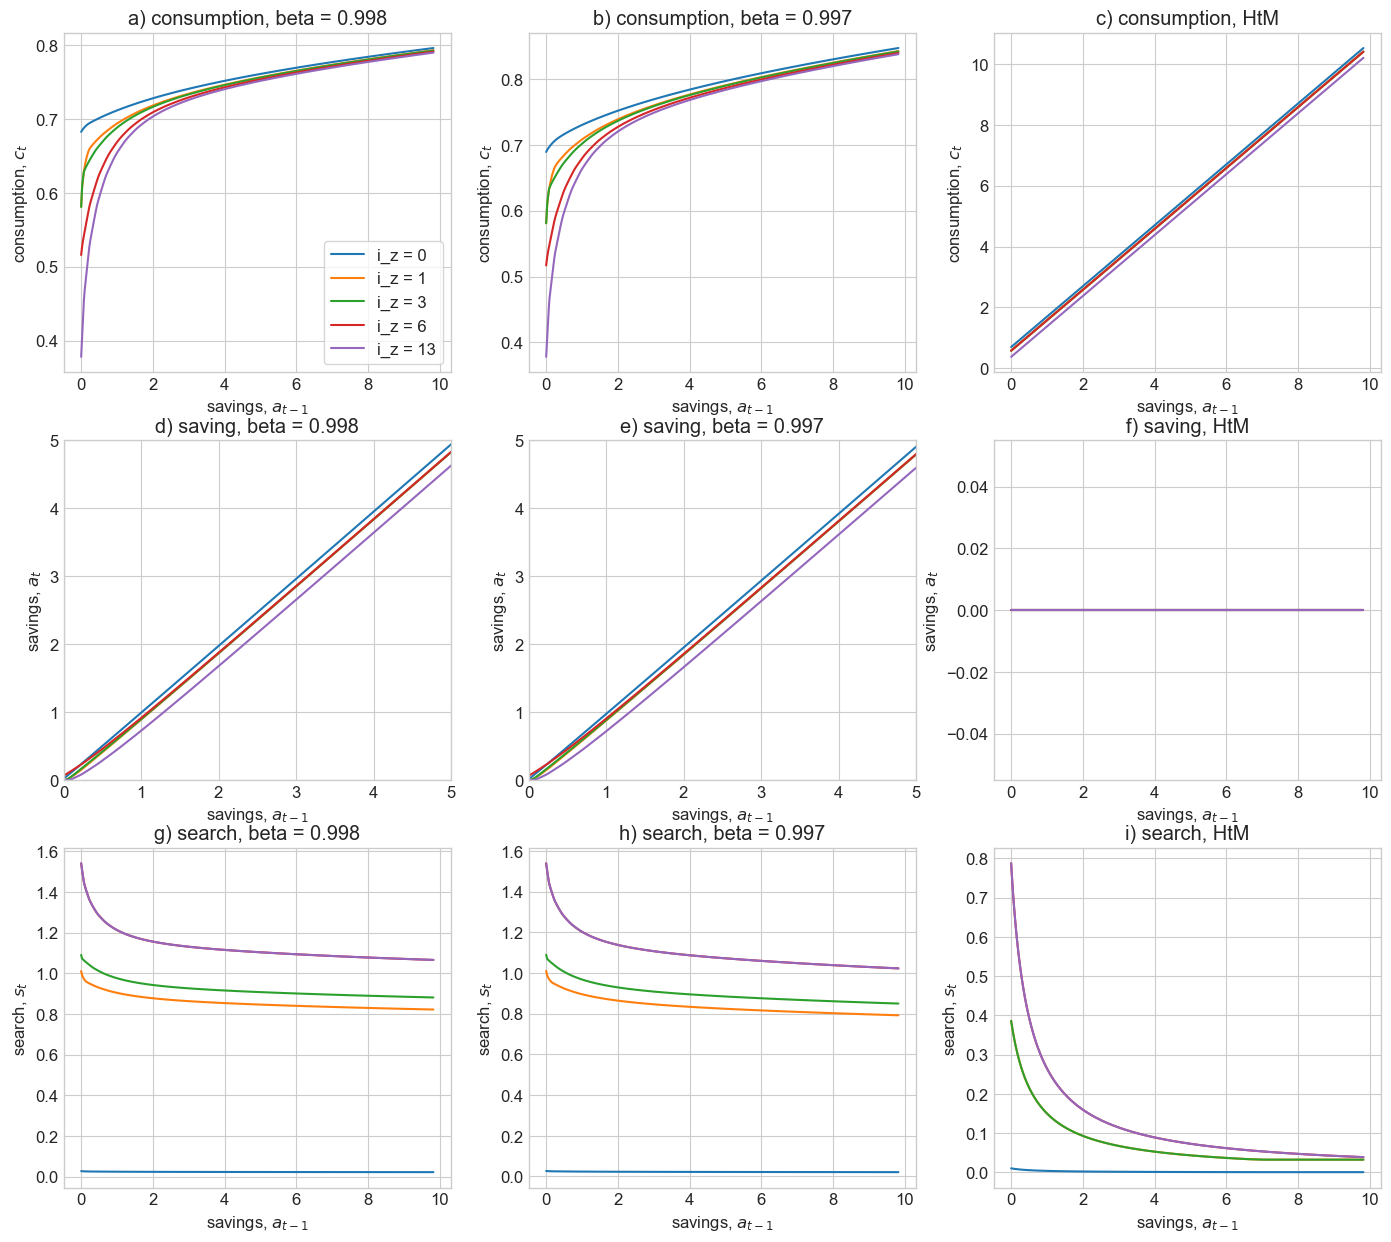

In [10]:
# Depict Policy Functions

beta_legend = par.beta_grid.round(3)

fig = plt.figure(figsize=(17,15),dpi=100)
a_max = 10

I = par.a_grid < a_max

k = 3

U_states = [0,1,3,6,13]

# a. consumption, patient
ax = fig.add_subplot(3,k,1)
ax.set_title(f'a) consumption, beta = 0.998')

for count, i_z in enumerate(U_states):
    ax.plot(par.a_grid[I],ss.c[2,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. consumption, impatient
ax = fig.add_subplot(3,k,2)
ax.set_title(f'b) consumption, beta = 0.997')

for count, i_z in enumerate(U_states):
    ax.plot(par.a_grid[I],ss.c[1,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# c. consumption, HTM
ax = fig.add_subplot(3,k,3)
ax.set_title(f'c) consumption, HtM')

for count, i_z in enumerate(U_states):
    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# d. saving, patient
ax = fig.add_subplot(3,k,4)
ax.set_title(f'd) saving, beta = 0.998')

for count, i_z in enumerate(U_states):
    ax.plot(par.a_grid[I],ss.a[2,i_z,I],label=f'i_z = {i_z}')

ax.set_xlim((0,5))
ax.set_ylim((0,5))

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# d. saving, impatient
ax = fig.add_subplot(3,k,5)
ax.set_title(f'e) saving, beta = 0.997')

for count, i_z in enumerate(U_states):
    ax.plot(par.a_grid[I],ss.a[1,i_z,I],label=f'i_z = {i_z}')

ax.set_xlim((0,5))
ax.set_ylim((0,5))

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# d. saving, HTM
ax = fig.add_subplot(3,k,6)
ax.set_title(f'f) saving, HtM')

for count, i_z in enumerate(U_states):
    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')


ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')
    
# c. search, patient
ax = fig.add_subplot(3,k,7)
ax.set_title(f'g) search, beta = 0.998')

for count, i_z in enumerate(U_states):
    ax.plot(par.a_grid[I],ss.s[2,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('search, $s_{t}$')

# c. search, impatient
ax = fig.add_subplot(3,k,8)
ax.set_title(f'h) search, beta = 0.997')

for count, i_z in enumerate(U_states):
    ax.plot(par.a_grid[I],ss.s[1,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('search, $s_{t}$')

# d. search, HTM
ax = fig.add_subplot(3,k,9)
ax.set_title(f'i) search, HtM')

for count, i_z in enumerate(U_states):
    ax.plot(par.a_grid[I],ss.s[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('search, $s_{t}$')


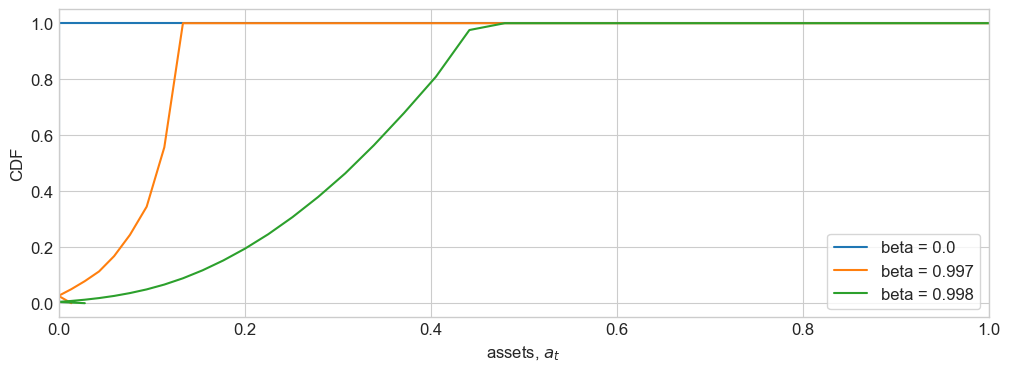

<Figure size 1200x400 with 0 Axes>

In [9]:
# Depict CDF

fig = plt.figure(figsize=(12,4),dpi=100)

# b. assets
ax = fig.add_subplot(1,1,1)
# ax.set_title('savings')
for i in range(par.Nfix):
    y = np.insert(np.cumsum(np.sum(ss.D[i],axis=0)),0,0.0)
    ax.plot(np.insert(par.a_grid,0,par.a_grid[i]),y/y[-1],label=f'beta = {par.beta_grid[i].round(3)}')
ax.set_xlim((0,1))
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
#ax.set_xscale('symlog')
fig = plt.figure(figsize=(12,4),dpi=100)
ax.legend(frameon=True)

# Functions

In [10]:
# Function for calculating gini coefficient

def gini(ss, par):
    
    D_new = np.sum(ss.D, axis = 0)

    RealR = 1.02**(1/12)
    
    # a. income
    inc_emp = par.a_grid*(RealR-1) + ss.w*(1-par.tau)
    inc_high = par.a_grid*(RealR-1) + ss.w*(1-par.tau)*par.UI_ratio_high
    inc_low = par.a_grid*(RealR-1) + ss.w*(1-par.tau)*par.UI_ratio_low
    
    #Distribution
    D_h = np.zeros((par.Na))
    D_l = np.zeros((par.Na))

    for i_a in range(par.Na):
        for i_z in range(par.Nz):
            if 0 < i_z < par.UI_duration + 1:
                D_h[i_a] += D_new[i_z,i_a] 
            elif i_z > par.UI_duration:
                D_l[i_a] += D_new[i_z,i_a]
    
    # Gini, total economy
    inc = np.concatenate((inc_low, inc_high, inc_emp))

    D_inc = np.concatenate((D_l, D_h, D_new[0]))

    inc_s, D_s = zip(*sorted(zip(inc, D_inc)))

    inc_s = tuple(ele1 * ele2 for ele1, ele2 in zip(inc_s, D_s))
    
    # Get Cumulative distribution
    x = np.insert(np.cumsum(D_s),0,0.0) 

    y_noscale = np.cumsum(inc_s)
    y = np.insert(y_noscale/y_noscale[-1],0,0.0)
    
    # calculate gini
    gini = (auc(y,y) - auc(x,y)) / auc(y,y)    
    
    return x, y, gini

In [11]:
# Function for calculating gini coefficient for only interest rate income

def gini_r(ss, par):
    
    D_new = np.sum(ss.D, axis = 0)
    
    D_r = np.sum(D_new,axis = 0)
    
    # a. income
    RealR = 1.02**(1/12)
    
    inc = par.a_grid*(RealR-1)

    inc_s, D_s = zip(*sorted(zip(inc, D_r)))

    inc_s = tuple(ele1 * ele2 for ele1, ele2 in zip(inc_s, D_s))
    
    # Get Cumulative distribution
    x = np.insert(np.cumsum(D_s),0,0.0) 

    y_noscale = np.cumsum(inc_s)
    y = np.insert(y_noscale/y_noscale[-1],0,0.0)
    
    # calculate gini
    gini = (auc(y,y) - auc(x,y)) / auc(y,y)    
    
    return x, y, gini

In [12]:
def get_cum_dist(V, D):
 
    #Patient households
    D_pat = D[2]
    V_pat = V[2]
    
    D_pat_re = D_pat.reshape(par.Nz*par.Na)
    V_pat_re = V_pat.reshape(par.Nz*par.Na)
    
    V_pat_re_s, D_pat_re_s = (list(t) for t in zip(*sorted(zip(V_pat_re, D_pat_re))))


    D_pat_cum_noscale = np.cumsum(D_pat_re_s)
    D_pat_f = D_pat_cum_noscale/D_pat_cum_noscale[-1]
    
    V_pat_re_s = np.array(V_pat_re_s, dtype=float)
    D_pat_f = np.array(D_pat_f, dtype=float)
    
    #Impatient part of popuation
    D_im = D[1]
    V_im = V[1]
    
    D_im_re = D_im.reshape(par.Nz*par.Na)
    V_im_re = V_im.reshape(par.Nz*par.Na)
    
    V_im_re_s, D_im_re_s = (list(t) for t in zip(*sorted(zip(V_im_re, D_im_re))))


    D_im_cum_noscale = np.cumsum(D_im_re_s)
    D_im_f = D_im_cum_noscale/D_im_cum_noscale[-1]
    
    V_im_re_s = np.array(V_im_re_s, dtype=float)
    D_im_f = np.array(D_im_f, dtype=float)
    
    # HtM households
    D_htm = D[0]
    V_htm = V[0]
        
    D_htm_re = D_htm.reshape(par.Nz*par.Na)
    V_htm_re = V_htm.reshape(par.Nz*par.Na)
    
    V_htm_re_s, D_htm_re_s = (list(t) for t in zip(*sorted(zip(V_htm_re, D_htm_re))))


    D_htm_cum_noscale = np.cumsum(D_htm_re_s)
    D_htm_f = D_htm_cum_noscale/D_htm_cum_noscale[-1]
    
    V_htm_re_s = np.array(V_htm_re_s, dtype=float)
    D_htm_f = np.array(D_htm_f, dtype=float)

        
    return V_pat_re_s, D_pat_f, V_im_re_s, D_im_f, V_htm_re_s, D_htm_f 

#Function for calculating value function at percentiele
def get_perc(V_pat_re_s, D_pat_f, V_im_re_s, D_im_f, V_htm_re_s, D_htm_f, perc):
    U_pat = 0.0
    U_im = 0.0
    U_htm = 0.0
    
    #a. patient households
    for j in range(len(D_pat_f)):
        if D_pat_f[j] > perc and D_pat_f[j-1] < perc:
            U_pat = V_pat_re_s[j-1] + (perc - D_pat_f[j-1]) * (V_pat_re_s[j] - V_pat_re_s[j-1]) / (D_pat_f[j]-D_pat_f[j-1]) 
        else:
            pass

    #b. impatient households
    for k in range(len(D_im_f)):
        if D_im_f[k] > perc and D_im_f[k-1] < perc:
            U_im = V_im_re_s[k-1] + (perc - D_im_f[k-1]) * (V_im_re_s[k] - V_im_re_s[k-1]) / (D_im_f[k]-D_im_f[k-1]) 
        else:
            pass
    
    # c. HtM households
    for i in range(len(D_htm_f)):
        if D_htm_f[i] > perc and D_htm_f[i-1] < perc:
            U_htm = V_htm_re_s[i-1] + (perc - D_htm_f[i-1]) * (V_htm_re_s[i] - V_htm_re_s[i-1]) / (D_htm_f[i]-D_htm_f[i-1]) 
        else:
            pass
        
    return U_pat, U_im, U_htm

# Steady state

In [17]:
# Compute ss for different UI ratios

UI_ratio_vec = np.linspace(0.54, 1.1, 29)

# Search
S_UI = np.nan + np.zeros(len(UI_ratio_vec))
S_UI_pol = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))
s_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
s_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
s_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

#savings 
A_UI_pol = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))
A_UI = np.nan + np.zeros(len(UI_ratio_vec))

a_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
a_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))
a_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))

V_UI = np.nan + np.zeros((len(UI_ratio_vec), len(par.beta_grid)))

# Consumption
C_UI_pol = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))

C_UI = np.nan + np.zeros(len(UI_ratio_vec))
c_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
c_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
c_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

# Unemployment rates
u_UI = np.nan + np.zeros(len(UI_ratio_vec))
u_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
u_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
u_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))
    
# Long term unemployed
u_UI_UI = np.nan + np.zeros(len(UI_ratio_vec))
u_UI_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
u_UI_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
u_UI_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

#ut unemployed
ut_UI = np.nan + np.zeros(len(UI_ratio_vec))
ut_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
ut_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
ut_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

#Unemployment fractions
frac_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
frac_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
frac_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

fracl_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
fracl_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
fracl_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

# for fractiles
D_f = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))
V_f = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))

Dbeg_UI = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))

# Gini
gini_UI = np.nan + np.zeros(len(UI_ratio_vec))
gini_r_UI = np.nan + np.zeros(len(UI_ratio_vec))

for i in range(len(UI_ratio_vec)):
    par.UI_ratio_high = UI_ratio_vec[i]
    print(par.UI_ratio_high)
    model.find_ss()
    
    # Search
    S_UI[i] = ss.S
    S_UI_pol[i] = ss.s
    Dbeg_UI[i] = ss.Dbeg 
    
    s_htm_UI[i] = np.sum(ss.s[0]*ss.Dbeg[0]) / np.sum(ss.Dbeg[0])
    s_im_UI[i] = np.sum(ss.s[1]*ss.Dbeg[1]) / np.sum(ss.Dbeg[1])
    s_pat_UI[i] = np.sum(ss.s[2]*ss.Dbeg[2]) / np.sum(ss.Dbeg[2])
    
    #savings 
    A_UI_pol[i] = ss.a

    A_UI[i] = ss.A_hh
    
    a_im_UI[i] = np.sum(ss.a[1]*ss.D[1]) / np.sum(ss.D[1])
    a_pat_UI[i] = np.sum(ss.a[2]*ss.D[2]) / np.sum(ss.D[2])
    a_htm_UI[i] = np.sum(ss.a[0]*ss.D[0]) / np.sum(ss.D[0])
    
    # Consumption
    C_UI_pol[i] = ss.c
    C_UI[i] = ss.C_hh
    
    c_htm_UI[i] = np.sum(ss.c[0]*ss.D[0]) / np.sum(ss.D[0])
    c_im_UI[i] = np.sum(ss.c[1]*ss.D[1]) / np.sum(ss.D[1])
    c_pat_UI[i] = np.sum(ss.c[2]*ss.D[2]) / np.sum(ss.D[2])
    
    # unemployment rates
    u_UI[i] = ss.u
    
    u_htm_UI[i] = np.sum(ss.D[0,1:]) / np.sum(ss.D[0])
    u_im_UI[i] = np.sum(ss.D[1,1:]) / np.sum(ss.D[1])
    u_pat_UI[i] = np.sum(ss.D[2,1:]) / np.sum(ss.D[2])
    
    # Long term unemployed
    u_UI_UI[i] = ss.U_UI_hh
    
    u_UI_htm_UI[i] = np.sum(ss.u_UI[0]*ss.D[0]) / np.sum(ss.D[0])
    u_UI_im_UI[i] = np.sum(ss.u_UI[1]*ss.D[1]) / np.sum(ss.D[1])
    u_UI_pat_UI[i] = np.sum(ss.u_UI[2]*ss.D[2]) / np.sum(ss.D[2])
    
    #ut unemployed
    ut_UI[i] = ss.ut
    
    ut_htm_UI[i] = (ss.delta*np.sum(ss.D[0,0]) + np.sum(ss.D[0,1:]))  / np.sum(ss.D[0])
    ut_im_UI[i] = (ss.delta*np.sum(ss.D[1,0]) + np.sum(ss.D[1,1:])) / np.sum(ss.D[1])
    ut_pat_UI[i] = (ss.delta*np.sum(ss.D[2,0]) + np.sum(ss.D[2,1:])) / np.sum(ss.D[2])
    
    #Fractions of total unemployment
    frac_htm_UI[i] = np.sum(ss.D[0,1:]) / np.sum(ss.D[0])
    frac_im_UI[i] = np.sum(ss.D[1,1:]) / np.sum(ss.D[1])
    frac_pat_UI[i] = np.sum(ss.D[2,1:]) / np.sum(ss.D[2])

    fracl_htm_UI[i] = np.sum(ss.D[0,7:]) / np.sum(ss.D[0])
    fracl_im_UI[i] = np.sum(ss.D[1,7:]) / np.sum(ss.D[1])
    fracl_pat_UI[i] = np.sum(ss.D[2,7:]) / np.sum(ss.D[2])

    V_UI[i] = [ np.sum(ss.D[0]*ss.V[0]) / np.sum(ss.D[0]), np.sum(ss.D[1]*ss.V[1]) / np.sum(ss.D[1]), np.sum(ss.D[2]*ss.V[2]) / np.sum(ss.D[2]) ]

    # For fractiles
    V_f[i] = ss.V
    D_f[i] = ss.D
    
    # For gini
    if np.min(ss.D) < 0:
        gini_UI[i] = 0.0
    else:
        _, _, gini_UI[i] = gini(ss,par)
        _, _, gini_r_UI[i] = gini_r(ss,par)
        


0.54
0.56
0.5800000000000001
0.6000000000000001
0.62
0.64
0.66
0.68
0.7000000000000001
0.72
0.74
0.76
0.78
0.8
0.8200000000000001
0.8400000000000001
0.8600000000000001
0.8800000000000001
0.9
0.92
0.9400000000000001
0.96
0.98
1.0
1.02
1.04
1.06
1.08
1.1


Text(0, 0.5, 'Fraction of population')

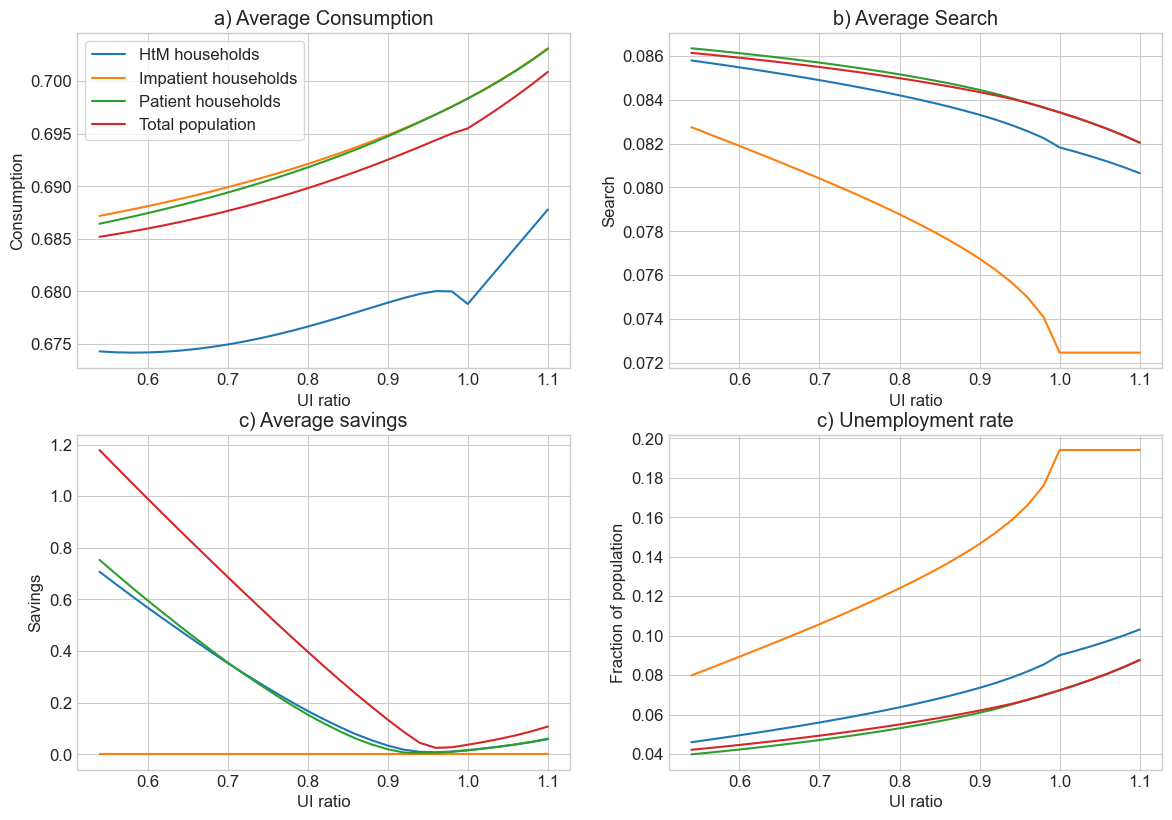

In [21]:
# Depict aggregates

fig = plt.figure(figsize=(14,20),dpi=100)

r = 4

# a. Aggregate Consumption
ax = fig.add_subplot(r,2,1)
ax.set_title(f'a) Average Consumption')

ax.plot(UI_ratio_vec, c_htm_UI, label = f'HtM households')
ax.plot(UI_ratio_vec, c_im_UI, label = f'Impatient households')
ax.plot(UI_ratio_vec, c_pat_UI, label = f'Patient households')
ax.plot(UI_ratio_vec, C_UI, label = f'Total population')

ax.legend(frameon = True)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Consumption')

# b. Aggregate Search
ax = fig.add_subplot(r,2,2)
ax.set_title(f'b) Average Search')

ax.plot(UI_ratio_vec, S_UI, label = f'Total population')
ax.plot(UI_ratio_vec, s_htm_UI, label = f'HtM households')
ax.plot(UI_ratio_vec, s_im_UI, label = f'Impatient households')
ax.plot(UI_ratio_vec, s_pat_UI, label = f'Patient households')

ax.set_xlabel('UI ratio')
ax.set_ylabel('Search')

# c. Savings
ax = fig.add_subplot(r,2,3)
ax.set_title(f'c) Average savings')

ax.plot(UI_ratio_vec, A_UI, label = f'Total population')
ax.plot(UI_ratio_vec, a_htm_UI, label = f'HtM households')
ax.plot(UI_ratio_vec, a_im_UI, label = f'Impatient households')
ax.plot(UI_ratio_vec, a_pat_UI, label = f'Patient households')

ax.set_xlabel('UI ratio')
ax.set_ylabel('Savings')

# c. Unemployment rate
ax = fig.add_subplot(r,2,4)
ax.set_title(f'c) Unemployment rate')

ax.plot(UI_ratio_vec, u_UI, label = f'Total population')
ax.plot(UI_ratio_vec, u_htm_UI, label = f'HtM households')
ax.plot(UI_ratio_vec, u_im_UI, label = f'Impatient households')
ax.plot(UI_ratio_vec, u_pat_UI, label = f'Patient households')

ax.set_xlabel('UI ratio')
ax.set_ylabel('Fraction of population')




Text(0, 0.5, 'Long-term unemployed')

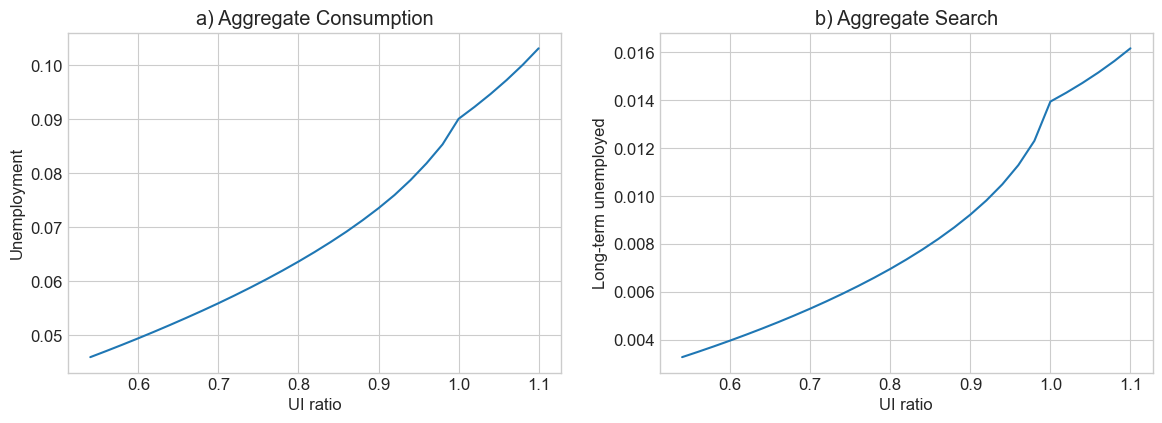

In [24]:
# Depict the results

fig = plt.figure(figsize=(14,15),dpi=100)

# a. Aggregate Consumption
ax = fig.add_subplot(3,2,1)
ax.set_title(f'a) Aggregate Consumption')

ax.plot(UI_ratio_vec, u_UI)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Unemployment')

# b. Aggregate Search
ax = fig.add_subplot(3,2,2)
ax.set_title(f'b) Aggregate Search')

ax.plot(UI_ratio_vec, u_UI - u_UI_UI)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Long-term unemployed')


Text(0, 0.5, 'Savings')

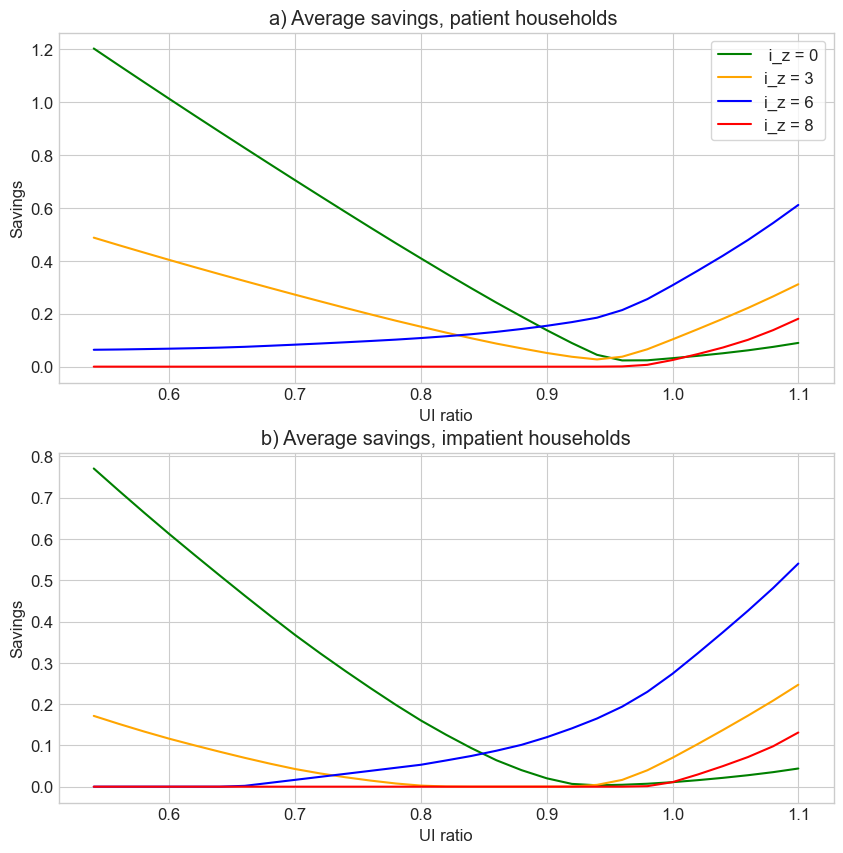

In [25]:
 # Depict savings for different unemployment states

g1 = 0
g2 = 3 
g3 = 6
g4 = 8

a0_pat = np.nan + np.zeros((len(UI_ratio_vec)))
a0_im  = np.nan + np.zeros((len(UI_ratio_vec)))

a3_pat = np.nan + np.zeros((len(UI_ratio_vec)))
a3_im = np.nan + np.zeros((len(UI_ratio_vec)))

a6_pat = np.nan + np.zeros((len(UI_ratio_vec)))
a6_im = np.nan + np.zeros((len(UI_ratio_vec)))

a8_pat = np.nan + np.zeros((len(UI_ratio_vec)))
a8_im = np.nan + np.zeros((len(UI_ratio_vec)))

for i in range(len(UI_ratio_vec)):
    a0_pat[i] = np.sum(A_UI_pol[i,2,g1]*D_f[i,2,g1]) / np.sum(D_f[i,2,g1])
    a0_im[i] = np.sum(A_UI_pol[i,1,g1]*D_f[i,1,g1]) / np.sum(D_f[i,1,g1])

    a3_pat[i] = np.sum(A_UI_pol[i,2,g2]*D_f[i,2,g2]) / np.sum(D_f[i,2,g2])
    a3_im[i] = np.sum(A_UI_pol[i,1,g2]*D_f[i,1,g2]) / np.sum(D_f[i,1,g2])

    a6_pat[i] = np.sum(A_UI_pol[i,2,g3]*D_f[i,2,g3]) / np.sum(D_f[i,2,g3])
    a6_im[i] = np.sum(A_UI_pol[i,1,g3]*D_f[i,1,g3]) / np.sum(D_f[i,1,g3])

    a8_pat[i] = np.sum(A_UI_pol[i,2,g4]*D_f[i,2,g4]) / np.sum(D_f[i,2,g4])
    a8_im[i] = np.sum(A_UI_pol[i,1,g4]*D_f[i,1,g4]) / np.sum(D_f[i,1,g4])

    
fig = plt.figure(figsize=(10,10),dpi=100)

# a. Aggregate Consumption
ax = fig.add_subplot(2,1,1)
ax.set_title(f'a) Average savings, patient households ')

ax.plot(UI_ratio_vec, a0_pat, label = f' i_z = {g1}', color = 'green')
ax.plot(UI_ratio_vec, a3_pat, label = f'i_z = {g2}', color = 'orange')
ax.plot(UI_ratio_vec, a6_pat, label = f'i_z = {g3}', color = 'blue')
ax.plot(UI_ratio_vec, a8_pat, label = f'i_z = {g4}', color = 'red')

ax.legend(frameon = True)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Savings')

# b. Aggregate Search
# f. Type fractions
ax = fig.add_subplot(2,1,2)
ax.set_title(f'b) Average savings, impatient households')

ax.plot(UI_ratio_vec, a0_im, label = f'i_z = {g1}, impat. households', color = 'green')
ax.plot(UI_ratio_vec, a3_im, label = f'i_z = {g2}, impat. households', color = 'orange')
ax.plot(UI_ratio_vec, a6_im, label = f'i_z = {g3}, impat. households', color = 'blue')
ax.plot(UI_ratio_vec, a8_im, label = f'i_z = {g4}, impat. households', color = 'red')

ax.set_xlabel('UI ratio')
ax.set_ylabel('Savings')


Text(0, 0.5, 'Average search intensity')

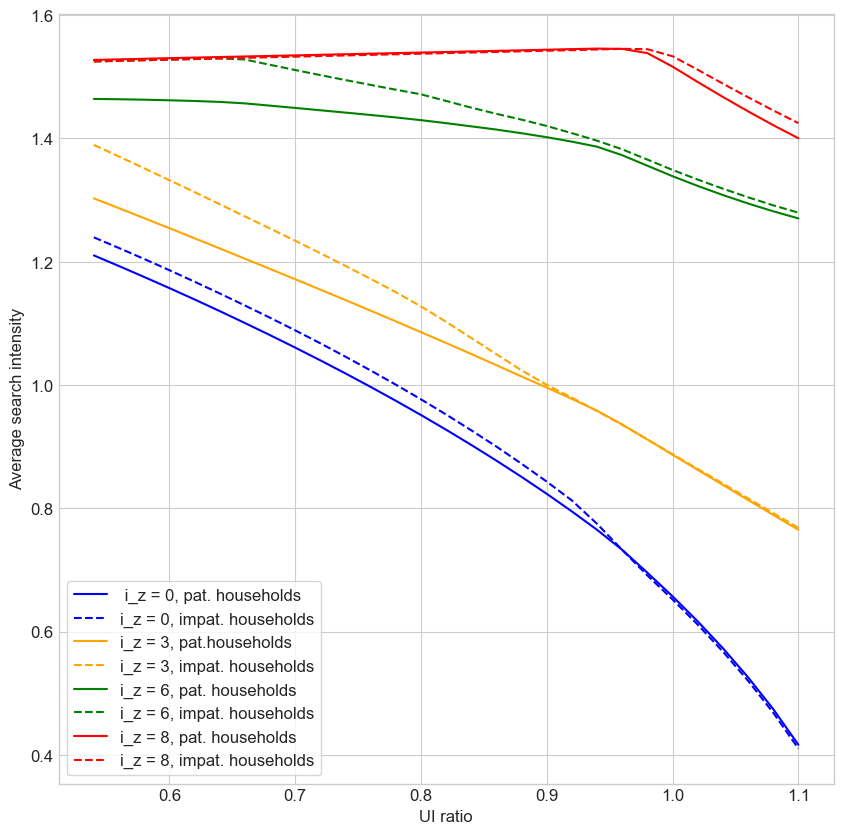

In [26]:
# Depict search for different unemployment states
g1 = 0
g2 = 3 
g3 = 6
g4 = 8

s0_pat = np.nan + np.zeros((len(UI_ratio_vec)))
s0_im  = np.nan + np.zeros((len(UI_ratio_vec)))

s3_pat = np.nan + np.zeros((len(UI_ratio_vec)))
s3_im = np.nan + np.zeros((len(UI_ratio_vec)))

s6_pat = np.nan + np.zeros((len(UI_ratio_vec)))
s6_im = np.nan + np.zeros((len(UI_ratio_vec)))

s8_pat = np.nan + np.zeros((len(UI_ratio_vec)))
s8_im = np.nan + np.zeros((len(UI_ratio_vec)))

for i in range(len(UI_ratio_vec)):
    
    s0_pat[i] = np.sum(S_UI_pol[i,2,g1]*Dbeg_UI[i,2,g1]) * 1/ss.delta / np.sum(D_f[i,2,g1])
    s0_im[i] = np.sum(S_UI_pol[i,1,g1]*Dbeg_UI[i,1,g1]) *1/ss.delta / np.sum(D_f[i,1,g1])

    s3_pat[i] = np.sum(S_UI_pol[i,2,g2]*Dbeg_UI[i,2,g2]) / np.sum(D_f[i,2,g2])
    s3_im[i] = np.sum(S_UI_pol[i,1,g2]*Dbeg_UI[i,1,g2]) / np.sum(D_f[i,1,g2])

    s6_pat[i] = np.sum(S_UI_pol[i,2,g3]*Dbeg_UI[i,2,g3]) / np.sum(D_f[i,2,g3])
    s6_im[i] = np.sum(S_UI_pol[i,1,g3]*Dbeg_UI[i,1,g3]) / np.sum(D_f[i,1,g3])

    s8_pat[i] = np.sum(S_UI_pol[i,2,g4]*Dbeg_UI[i,2,g4]) / np.sum(D_f[i,2,g4])
    s8_im[i] = np.sum(S_UI_pol[i,1,g4]*Dbeg_UI[i,1,g4]) / np.sum(D_f[i,1,g4])


fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(1,1,1)

ax.plot(UI_ratio_vec, s0_pat, label = f' i_z = {g1}, pat. households', color = 'blue')
ax.plot(UI_ratio_vec, s0_im, label = f'i_z = {g1}, impat. households', color = 'blue', linestyle = 'dashed' )
                          
ax.plot(UI_ratio_vec, s3_pat, label = f'i_z = {g2}, pat.households', color = 'orange')
ax.plot(UI_ratio_vec, s3_im, label = f'i_z = {g2}, impat. households', color = 'orange', linestyle = 'dashed' )
                          
ax.plot(UI_ratio_vec, s6_pat, label = f'i_z = {g3}, pat. households', color = 'green')
ax.plot(UI_ratio_vec, s6_im, label = f'i_z = {g3}, impat. households', color = 'green', linestyle = 'dashed' )

ax.plot(UI_ratio_vec, s8_pat, label = f'i_z = {g4}, pat. households', color = 'red')
ax.plot(UI_ratio_vec, s8_im, label = f'i_z = {g4}, impat. households', color = 'red', linestyle = 'dashed' )
ax.legend(frameon = True) 

ax.set_xlabel('UI ratio')
ax.set_ylabel('Average search intensity')

Text(0, 0.5, 'Ratio')

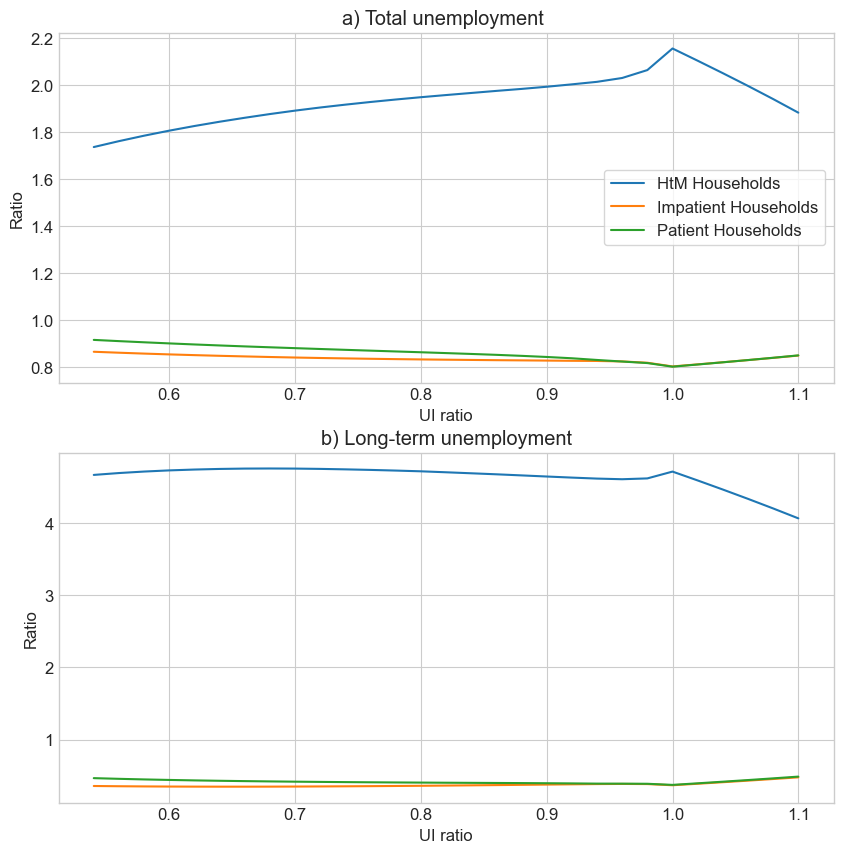

In [24]:
# Depict unemployment rates for each unemployment relative to the total unemployment rate

fig = plt.figure(figsize=(10,10),dpi=100)

# a. Aggregate Consumption
ax = fig.add_subplot(2,1,1)
ax.set_title(f'a) Total unemployment ')

ax.plot(UI_ratio_vec, frac_htm_UI / u_UI, label = f'HtM Households')
ax.plot(UI_ratio_vec, frac_im_UI / u_UI, label = f'Impatient Households')
ax.plot(UI_ratio_vec, frac_pat_UI / u_UI , label = f'Patient Households')

ax.legend(frameon = True)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Ratio')

# b. Aggregate Search
# f. Type fractions
ax = fig.add_subplot(2,1,2)
ax.set_title(f'b) Long-term unemployment')

ax.plot(UI_ratio_vec, fracl_htm_UI / (u_UI - u_UI_UI), label = f'HtM Households')
ax.plot(UI_ratio_vec, fracl_im_UI / (u_UI - u_UI_UI), label = f'Impatient Households')
ax.plot(UI_ratio_vec, fracl_pat_UI / (u_UI -u_UI_UI) , label = f'Patient Households')
        
ax.set_xlabel('UI ratio')
ax.set_ylabel('Ratio')

In [26]:
# Calculate value functions at percentiles

# a. make sure that distribution only containins elements > 0
for k in range(len(UI_ratio_vec)):
    if np.min(D_f[k]) > 0 and np.min(D_f[k-1]) < 0:
        break
    elif np.min(D_f[k]) == 0 and np.min(D_f[k-1]) < 0:
        break
    else:
        k = 0

shape = par.Nz*par.Na
UI_rat_vec_f = UI_ratio_vec[k:]

perc_vec = [0.01, 0.02, 0.04, 0.06]

# Initialize
cum_f_pat = np.nan + np.zeros((len(UI_rat_vec_f), shape))
V_f_pat = np.nan + np.zeros((len(UI_rat_vec_f), shape))
cum_f_im = np.nan + np.zeros((len(UI_rat_vec_f), shape))
V_f_im = np.nan + np.zeros((len(UI_rat_vec_f), shape))
cum_f_htm = np.nan + np.zeros((len(UI_rat_vec_f), shape))
V_f_htm = np.nan + np.zeros((len(UI_rat_vec_f), shape))

U_goal_pat = np.nan + np.zeros((len(UI_rat_vec_f), len(perc_vec)))
U_goal_im = np.nan + np.zeros((len(UI_rat_vec_f), len(perc_vec)))
U_goal_htm = np.nan + np.zeros((len(UI_rat_vec_f), len(perc_vec)))

# Calculate percentiles
for i in range(len(UI_rat_vec_f[k:])):
    mat_V = V_f[i+k]
    mat_D = D_f[i+k]
    
    V_f_pat[i], cum_f_pat[i], V_f_im[i], cum_f_im[i],  V_f_htm[i], cum_f_htm[i]  = get_cum_dist(mat_V, mat_D)
    
    for j in range(len(perc_vec)):
        U_goal_pat[i,j], U_goal_im[i,j], U_goal_htm[i,j] = get_perc(V_f_pat[i], cum_f_pat[i], V_f_im[i], cum_f_im[i],  V_f_htm[i], cum_f_htm[i], perc_vec[j])

Text(0, 0.5, 'Value function')

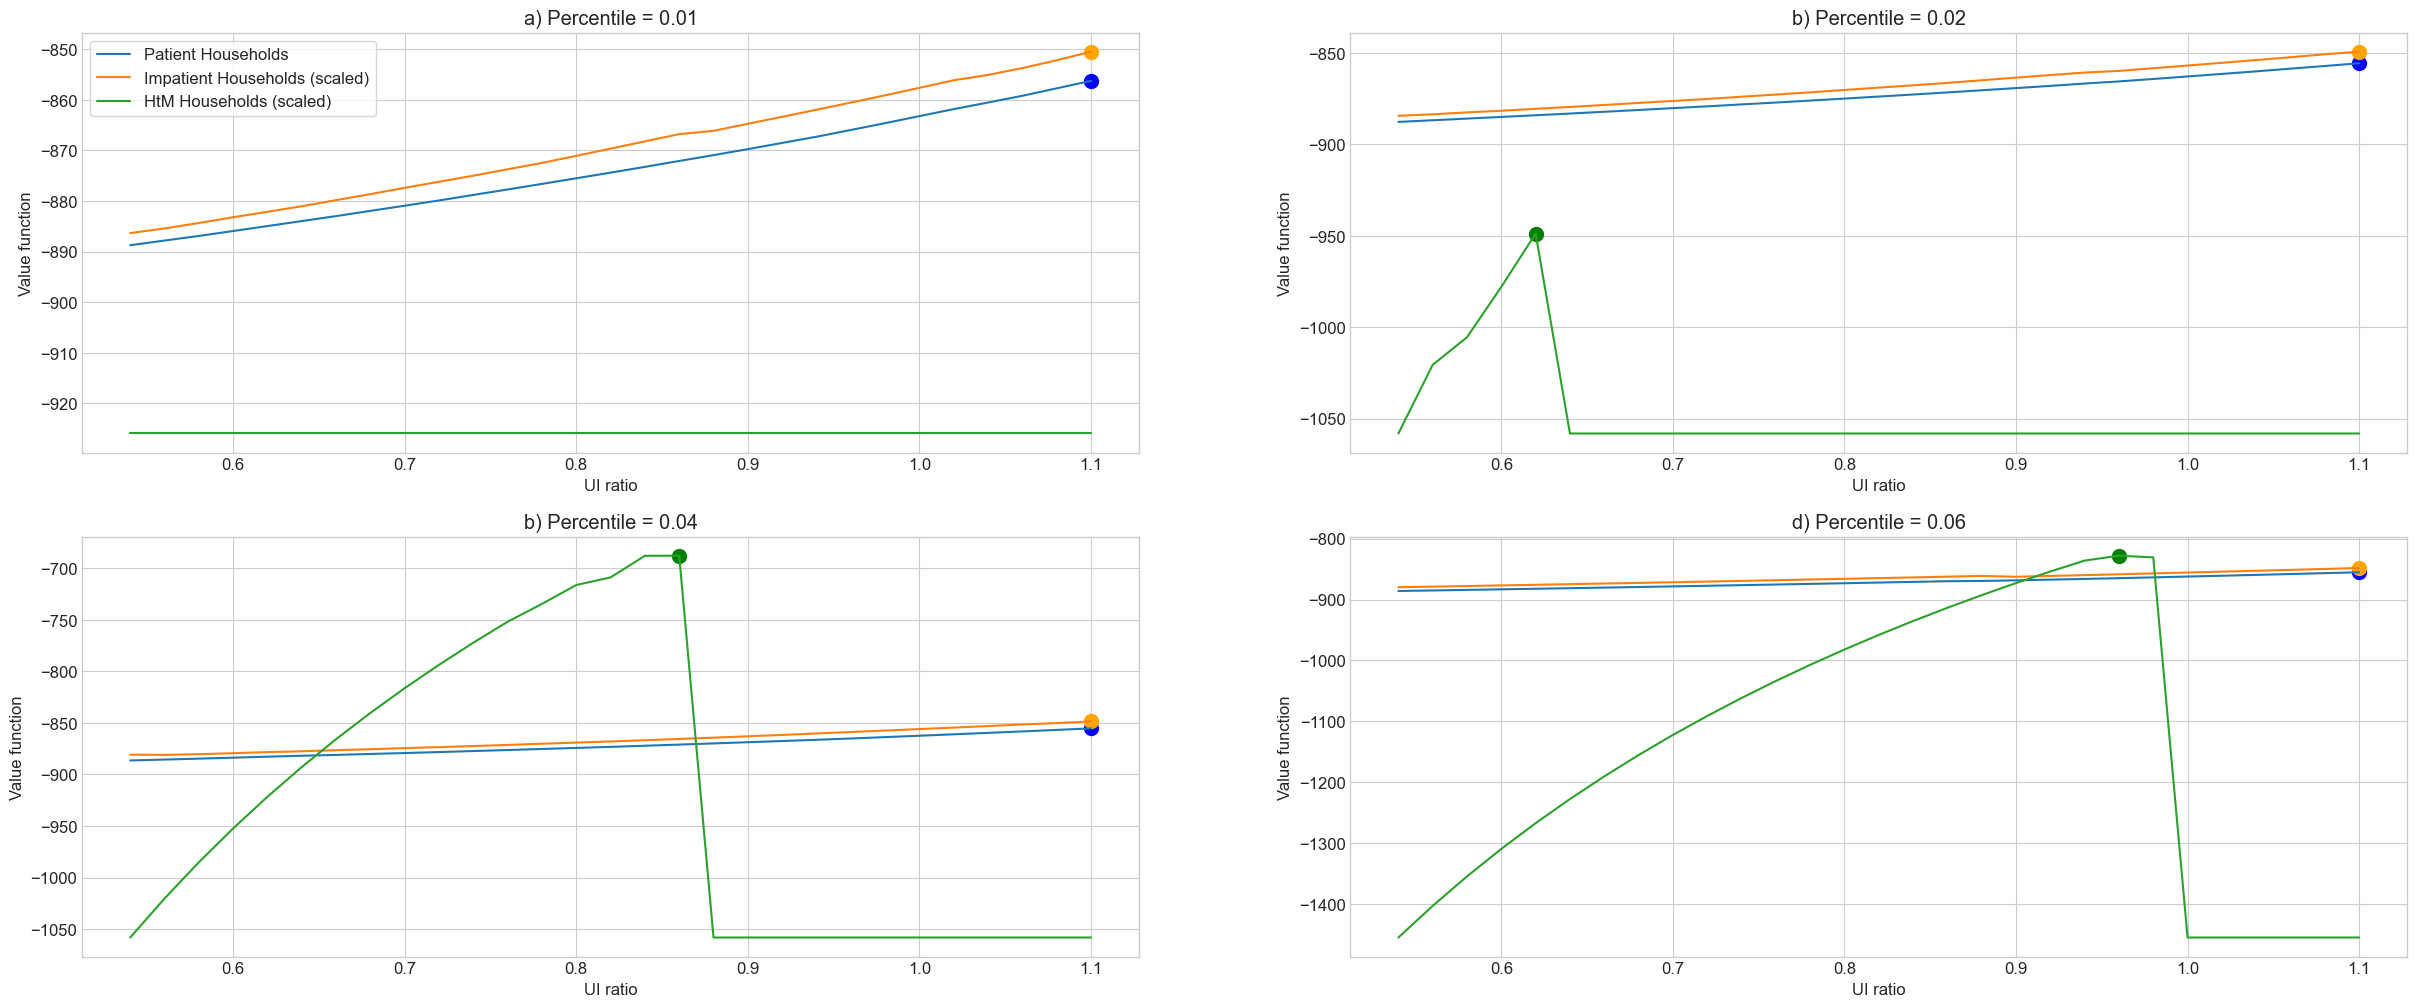

In [31]:
#Depict percentiles
fig = plt.figure(figsize=(30,12),dpi=100)


ax = fig.add_subplot(2,2,1)
ax.set_title(f'a) Percentile = {perc_vec[0]}')

ax.plot(UI_rat_vec_f, U_goal_pat[:,0], label = 'Patient Households')
ax.plot(UI_rat_vec_f, U_goal_im[:,0]*2, label = 'Impatient Households (scaled)')
ax.plot(UI_rat_vec_f, U_goal_htm[:,0]*350, label = 'HtM Households (scaled)')

ax.scatter(UI_rat_vec_f[np.argmax(U_goal_pat[:,0])],U_goal_pat[:,0][np.argmax(U_goal_pat[:,0])], color='blue', s = 100)
ax.scatter(UI_rat_vec_f[np.argmax(U_goal_im[:,0])],U_goal_im[:,0][np.argmax(U_goal_im[:,0])]*2, color='orange', s = 100)
# ax.scatter(UI_rat_vec_f[np.argmax(U_goal_htm[:,0])],U_goal_htm[:,0][np.argmax(U_goal_htm[:,0])]*350, color='green', s = 100)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Value function')

ax.legend(frameon=True)

ax = fig.add_subplot(2,2,2)
ax.set_title(f'b) Percentile = {perc_vec[1]}')

ax.plot(UI_rat_vec_f, U_goal_pat[:,1])
ax.plot(UI_rat_vec_f, U_goal_im[:,1]*2)
ax.plot(UI_rat_vec_f, U_goal_htm[:,1]*400)

ax.scatter(UI_rat_vec_f[np.argmax(U_goal_pat[:,1])],U_goal_pat[:,1][np.argmax(U_goal_pat[:,1])], color='blue', s = 100)
ax.scatter(UI_rat_vec_f[np.argmax(U_goal_im[:,1])],U_goal_im[:,1][np.argmax(U_goal_im[:,1])]*2, color='orange', s = 100)
ax.scatter(UI_rat_vec_f[np.argmax(U_goal_htm[:,1])],U_goal_htm[:,1][np.argmax(U_goal_htm[:,1])]*400, color='green', s = 100)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Value function')

ax = fig.add_subplot(2,2,3)
ax.set_title(f'b) Percentile = {perc_vec[2]}')

ax.plot(UI_rat_vec_f, U_goal_pat[:,2])
ax.plot(UI_rat_vec_f, U_goal_im[:,2]*2)
ax.plot(UI_rat_vec_f, U_goal_htm[:,2]*400)

ax.scatter(UI_rat_vec_f[np.argmax(U_goal_pat[:,2])],U_goal_pat[:,2][np.argmax(U_goal_pat[:,2])], color='blue', s = 100)
ax.scatter(UI_rat_vec_f[np.argmax(U_goal_im[:,2])],U_goal_im[:,2][np.argmax(U_goal_im[:,2])]*2, color='orange', s = 100)
ax.scatter(UI_rat_vec_f[np.argmax(U_goal_htm[:,2])],U_goal_htm[:,2][np.argmax(U_goal_htm[:,2])]*400, color='green', s = 100)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Value function')

ax = fig.add_subplot(2,2,4)
ax.set_title(f'd) Percentile = {perc_vec[3]}')

ax.plot(UI_rat_vec_f, U_goal_pat[:,3])
ax.plot(UI_rat_vec_f, U_goal_im[:,3]*2)
ax.plot(UI_rat_vec_f, U_goal_htm[:,3]*550)

ax.scatter(UI_rat_vec_f[np.argmax(U_goal_pat[:,3])],U_goal_pat[:,3][np.argmax(U_goal_pat[:,3])], color='blue', s = 100)
ax.scatter(UI_rat_vec_f[np.argmax(U_goal_im[:,3])],U_goal_im[:,3][np.argmax(U_goal_im[:,3])]*2, color='orange', s = 100)
ax.scatter(UI_rat_vec_f[np.argmax(U_goal_htm[:,3])],U_goal_htm[:,3][np.argmax(U_goal_htm[:,3])]*550, color='green', s = 100)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Value function')


Text(0, 0.5, 'Value funtion, V')

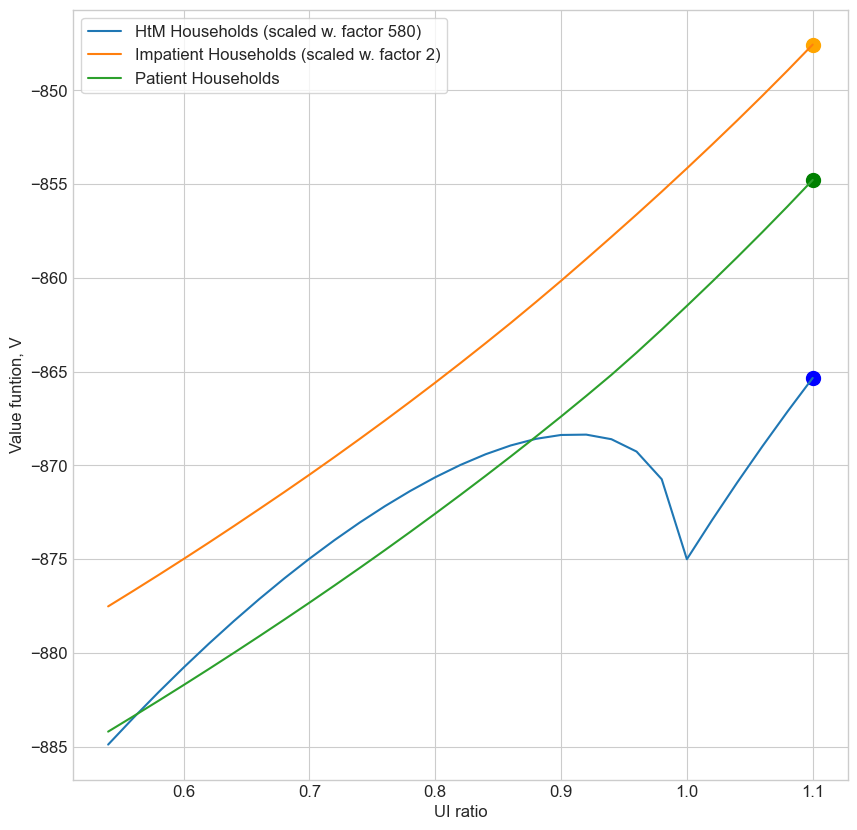

In [22]:
# Depict value functions

fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(1,1,1)

ax.plot(UI_ratio_vec, V_UI[:,0]*580, label = f'HtM Households (scaled w. factor 580)' )
ax.plot(UI_ratio_vec, V_UI[:,1]*2, label = f'Impatient Households (scaled w. factor 2)')
ax.plot(UI_ratio_vec, V_UI[:,2], label = f'Patient Households')

ax.scatter(UI_ratio_vec[np.argmax(V_UI[:,0])],V_UI[:,0][np.argmax(V_UI[:,0])]*580, color='blue', s = 100)
ax.scatter(UI_ratio_vec[np.argmax(V_UI[:,1])],V_UI[:,1][np.argmax(V_UI[:,1])]*2, color='orange', s = 100)
ax.scatter(UI_ratio_vec[np.argmax(V_UI[:,2])],V_UI[:,2][np.argmax(V_UI[:,2])], color='green', s = 100)


ax.legend(frameon = True)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Value funtion, V')

Text(0, 0.5, 'Gini Coefficient')

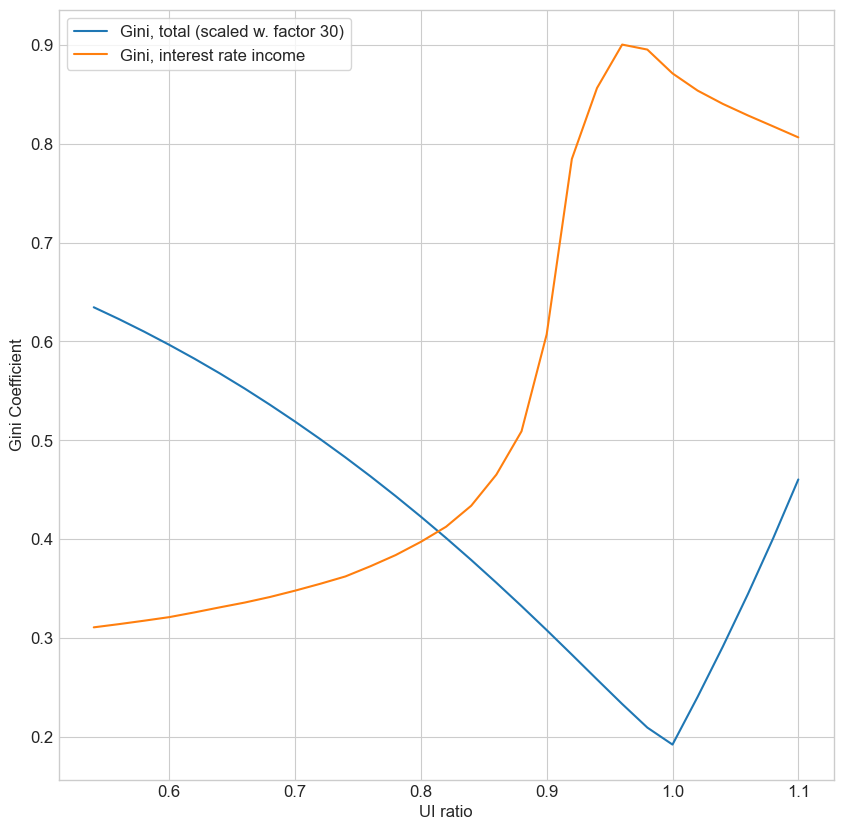

In [27]:
# Make sure distribution only contains elements > 0
for i in range(len(UI_ratio_vec)):
    if gini_UI[i] > 0 and gini_UI[i-1] == 0:
        break
    else:
        i = 0

fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(1,1,1)

ax.plot(UI_ratio_vec[i:], gini_UI[i:]*30, label = 'Gini, total (scaled w. factor 30)')
ax.plot(UI_ratio_vec[i:], gini_r_UI[i:], label = 'Gini, interest rate income')

ax.legend(frameon = True)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Gini Coefficient')